# Projet IPEO

### Data loading

In [1]:
import os
import random
from collections import defaultdict

import torch
from torchvision import datasets, transforms
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
import matplotlib.pyplot as plt
import numpy as np

/opt/miniconda3/envs/hurricane/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/miniconda3/envs/hurricane/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /opt/miniconda3/envs/hurricane/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/miniconda3/envs/hurricane/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/miniconda3/envs/hurricane/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/miniconda3/envs/hurricane/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/miniconda3/envs/hurricane/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environm

Device utilisé : cpu
Classes : ['damage', 'no_damage']
Nombre d'images (train) : 19000
Nombre d'images (val) : 2000
Nombre d'images (test) : 2000


/opt/miniconda3/envs/hurricane/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/miniconda3/envs/hurricane/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /opt/miniconda3/envs/hurricane/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/miniconda3/envs/hurricane/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/miniconda3/envs/hurricane/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/miniconda3/envs/hurricane/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/miniconda3/envs/hurricane/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environm

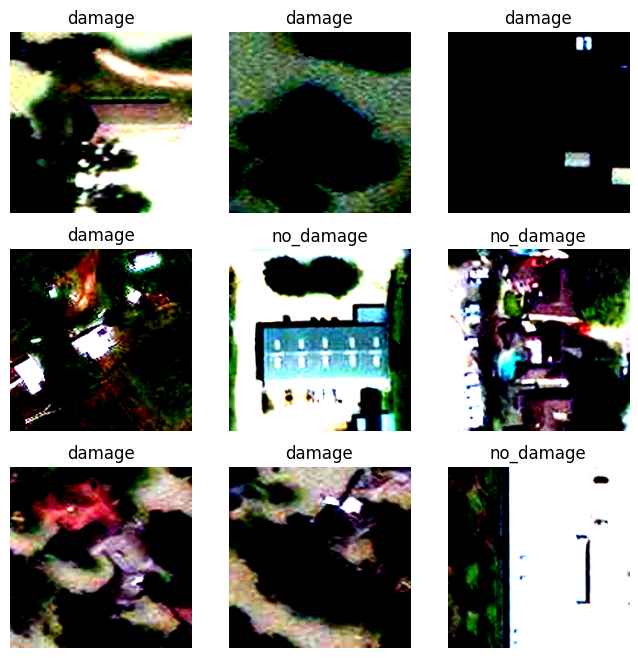

In [2]:
base_dir = "ipeo_hurricane_for_students"

mean = torch.tensor([0.3520655930042267, 0.3834735155105591, 0.28522437810897827])
std = torch.tensor([0.14353738725185394, 0.12388758361339569, 0.12524260580539703])

normalize = T.Normalize(mean, std)

default_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    normalize
])


train_ds = datasets.ImageFolder(os.path.join(base_dir, "train"), transform=default_transform)
val_ds   = datasets.ImageFolder(os.path.join(base_dir, "validation"), transform=default_transform)
test_ds  = datasets.ImageFolder(os.path.join(base_dir, "test"), transform=default_transform)

# Détection du device (GPU si disponible, sinon CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device utilisé :", device)


# Ajustements DataLoader pour CPU (si pas de GPU) : réduire batch_size si besoin, num_workers=0 sur macOS (2 dans le cours)
# à voir si on garde ça comme ça
batch_size = 16
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=False)
val_loader   = DataLoader(val_ds, batch_size=batch_size, num_workers=2, pin_memory=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, num_workers=2, pin_memory=False)

print("Classes :", train_ds.classes)
print("Nombre d'images (train) :", len(train_ds))
print("Nombre d'images (val) :", len(val_ds))
print("Nombre d'images (test) :", len(test_ds))

def show_batch(loader):
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    for img, label, ax in zip(images[:9], labels[:9], axes.flat):
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(train_ds.classes[label])
        ax.axis("off")
    plt.show()

show_batch(train_loader)

### Model loading

In [3]:
from torchvision.models import resnet34, mobilenet_v3_small


# load a resnet34 with 2 classes (damage vs no_damage) and move to device
model_resnet = resnet34(num_classes=2).to(device)
model_resnet

# load a mobilnet_v3_small with 2 classes (damage vs no_damage) and move to device
model_mobilenet = mobilenet_v3_small(num_classes=2).to(device)
model_mobilenet

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

### Loss function with Class Balancing

In [4]:
# Compute class weights to handle imbalanced dataset
from collections import Counter

def compute_class_weights(dataset, device):
    """Calcule les poids pour chaque classe (inverse de la fréquence)"""
    # Compter les occurrences de chaque classe
    labels = [label for _, label in dataset]
    class_counts = Counter(labels)
    
    # Calculer les poids (inverse de la fréquence)
    total_samples = len(labels)
    num_classes = len(class_counts)
    class_weights = torch.zeros(num_classes)
    
    for class_id, count in class_counts.items():
        class_weights[class_id] = total_samples / (num_classes * count)
    
    return class_weights.to(device)

# Calculer les class weights sur le training set
class_weights = compute_class_weights(train_ds, device)
print(f"✓ Class weights computed:")
for i, weight in enumerate(class_weights):
    print(f"   Class {train_ds.classes[i]}: {weight:.4f}")

# Define the loss function with class weights
criterion = CrossEntropyLoss(weight=class_weights)

✓ Class weights computed:
   Class damage: 0.7308
   Class no_damage: 1.5833


### Optimizer

In [5]:
from torch.optim import SGD

learning_rate = 0.01
weight_decay = 1e-4    # Régularisation L2 (évite l'overfitting)

optimizer_resnet = SGD(model_resnet.parameters(),lr=learning_rate,weight_decay=weight_decay)
optimizer_mobilenet = SGD(model_mobilenet.parameters(),lr=learning_rate,weight_decay=weight_decay)

### Training step

In [6]:
import torch.nn.functional as F

def training_step(batch, model, optimizer, device):
    model.train()
    optimizer.zero_grad()

    x, y = batch
    x = x.to(device)
    y = y.to(device)

    y_hat = model(x)
    loss = criterion(y_hat, y)

    loss.backward()
    optimizer.step()

    preds = y_hat.argmax(1).cpu().detach().numpy()
    gt = y.cpu().detach().numpy()
    accuracy = (preds == gt).mean()

    return loss.item(), float(accuracy)


### Training and validating over the full batch

In [7]:
import numpy as np

def train_epoch(train_dl, model, optimizer, device):

    # collect some statistics
    losses, accuracies = [], []
    total_batches = len(train_dl)
    print(f"Training: {total_batches} batches to process")

    for batch_idx, batch in enumerate(train_dl, 1):
        loss, accuracy = training_step(batch, model, optimizer, device)

        # append statistics (loss is a float already)
        losses.append(loss)
        accuracies.append(accuracy)
        
        # Print progress every 10 batches
        if batch_idx % 10 == 0 or batch_idx == total_batches:
            print(f"  Batch {batch_idx}/{total_batches} - loss: {loss:.4f}, acc: {accuracy*100:.2f}%")

    # protections si listes vides
    if len(losses) == 0:
        return 0.0, 0.0

    # return averaged losses and accuracies
    return float(np.mean(losses)), float(np.mean(accuracies))


def validate_epoch(val_dl, model, device):
    """Évalue le modèle sur l'ensemble de validation (sans backprop)."""
    model.eval()
    losses, accuracies = [], []

    with torch.no_grad():  # pas de gradient pour la validation
        for batch in val_dl:
            x, y = batch
            x = x.to(device)
            y = y.to(device)

            y_hat = model(x)
            loss = criterion(y_hat, y)

            preds = y_hat.argmax(1).cpu().detach().numpy()
            gt = y.cpu().detach().numpy()
            accuracy = (preds == gt).mean()

            losses.append(loss.item())
            accuracies.append(accuracy)

    if len(losses) == 0:
        return 0.0, 0.0

    return float(np.mean(losses)), float(np.mean(accuracies))

In [8]:
num_epochs = 50  # Augmentez à 50, early stopping arrêtera avant si nécessaire
import os
import json

# Create models directory if it doesn't exist
os.makedirs("models", exist_ok=True)

# ============ EARLY STOPPING CONFIGURATION ============
patience = 5  # Nombre d'epochs sans amélioration avant d'arrêter
min_delta = 0.001  # Amélioration minimale considérée (0.1%)
# ====================================================

# Vérifier si les modèles ET les stats existent
models_exist = (os.path.exists("models/mobilenet_test.pth") and 
                os.path.exists("models/resnet_test.pth") and 
                os.path.exists("models/stats_test.json"))

if models_exist:
    # Charger les modèles (map_location pour compatibilité CPU/GPU)
    model_mobilenet.load_state_dict(torch.load("models/mobilenet_test.pth", map_location=device))
    model_resnet.load_state_dict(torch.load("models/resnet_test.pth", map_location=device))
    print("✅ MobileNet loaded from models/mobilenet_test.pth")
    print("✅ ResNet loaded from models/resnet_test.pth")
    
    # Charger les stats
    with open("models/stats_test.json", "r") as f:
        saved_stats = json.load(f)
        stats_mobilenet = saved_stats["mobilenet"]
        stats_resnet = saved_stats["resnet"]
    print("✅ Stats loaded from models/stats_test.json")
    print("\n⏭️ TRAINING SKIPPED - using pre-trained models and stats")
    train_models = False
else:
    print("🔄 Starting training (models or stats not found)...")
    print(f"⚙️  Early stopping enabled: patience={patience} epochs, min_delta={min_delta*100:.1f}%")
    train_models = True

# ENTRAÎNER SEULEMENT SI LES MODÈLES N'EXISTENT PAS
if train_models:
    # ============ TRAINING MOBILENET ============
    print(f"\n{'='*80}")
    print("TRAINING MOBILENET WITH EARLY STOPPING")
    print(f"{'='*80}")
    
    stats_mobilenet = []
    best_val_acc_mobilenet = 0
    patience_counter_mobilenet = 0
    
    for epoch in range(num_epochs):
        print(f"\n{'='*60}")
        print(f"MOBILENET - Epoch {epoch+1}/{num_epochs}")
        print(f"{'='*60}")
        trainloss_mobilenet, trainaccuracy_mobilenet = train_epoch(train_loader, model_mobilenet, optimizer_mobilenet, device)
        valloss_mobilenet, valaccuracy_mobilenet = validate_epoch(val_loader, model_mobilenet, device)

        print(f"epoch {epoch}; trainloss {trainloss_mobilenet:.4f}, train accuracy {trainaccuracy_mobilenet*100:.2f}% | valloss {valloss_mobilenet:.4f}, val accuracy {valaccuracy_mobilenet*100:.2f}%")

        stats_mobilenet.append({
            "trainloss": float(trainloss_mobilenet),
            "trainaccuracy": float(trainaccuracy_mobilenet),
            "valloss": float(valloss_mobilenet),
            "valaccuracy": float(valaccuracy_mobilenet),
            "epoch": epoch
        })

        # ====== EARLY STOPPING LOGIC ======
        if valaccuracy_mobilenet > best_val_acc_mobilenet + min_delta:
            best_val_acc_mobilenet = valaccuracy_mobilenet
            patience_counter_mobilenet = 0
            # Sauvegarder le meilleur modèle
            torch.save(model_mobilenet.state_dict(), "models/mobilenet_test.pth")
            print(f"✅ New best val accuracy: {best_val_acc_mobilenet*100:.2f}% - Model saved!")
        else:
            patience_counter_mobilenet += 1
            print(f"⏱️  No improvement. Patience: {patience_counter_mobilenet}/{patience}")
            
            if patience_counter_mobilenet >= patience:
                print(f"\n🛑 Early stopping triggered! No improvement for {patience} epochs.")
                print(f"   Best validation accuracy: {best_val_acc_mobilenet*100:.2f}%")
                break
        # ==================================

    print("✅ Mobilenet training completed (or early stopped)")

    # ============ TRAINING RESNET ============
    print(f"\n{'='*80}")
    print("TRAINING RESNET34 WITH EARLY STOPPING")
    print(f"{'='*80}")
    
    stats_resnet = []
    best_val_acc_resnet = 0
    patience_counter_resnet = 0
    
    for epoch in range(num_epochs):
        print(f"\n{'='*60}")
        print(f"RESNET - Epoch {epoch+1}/{num_epochs}")
        print(f"{'='*60}")
        trainloss_resnet, trainaccuracy_resnet = train_epoch(train_loader, model_resnet, optimizer_resnet, device)
        valloss_resnet, valaccuracy_resnet = validate_epoch(val_loader, model_resnet, device)

        print(f"epoch {epoch}; trainloss {trainloss_resnet:.4f}, train accuracy {trainaccuracy_resnet*100:.2f}% | valloss {valloss_resnet:.4f}, val accuracy {valaccuracy_resnet*100:.2f}%")

        stats_resnet.append({
            "trainloss": float(trainloss_resnet),
            "trainaccuracy": float(trainaccuracy_resnet),
            "valloss": float(valloss_resnet),
            "valaccuracy": float(valaccuracy_resnet),
            "epoch": epoch
        })

        # ====== EARLY STOPPING LOGIC ======
        if valaccuracy_resnet > best_val_acc_resnet + min_delta:
            best_val_acc_resnet = valaccuracy_resnet
            patience_counter_resnet = 0
            # Sauvegarder le meilleur modèle
            torch.save(model_resnet.state_dict(), "models/resnet_test.pth")
            print(f"✅ New best val accuracy: {best_val_acc_resnet*100:.2f}% - Model saved!")
        else:
            patience_counter_resnet += 1
            print(f"⏱️  No improvement. Patience: {patience_counter_resnet}/{patience}")
            
            if patience_counter_resnet >= patience:
                print(f"\n🛑 Early stopping triggered! No improvement for {patience} epochs.")
                print(f"   Best validation accuracy: {best_val_acc_resnet*100:.2f}%")
                break
        # ==================================

    print("✅ ResNet training completed (or early stopped)")
    
    # Save stats as JSON
    with open("models/stats_test.json", "w") as f:
        json.dump({"mobilenet": stats_mobilenet, "resnet": stats_resnet}, f)
    print("✅ Stats saved to models/stats_test.json")
else:
    print("\n⏭️ TRAINING SKIPPED - using pre-trained models and stats")


✅ MobileNet loaded from models/mobilenet_test.pth
✅ ResNet loaded from models/resnet_test.pth
✅ Stats loaded from models/stats_test.json

⏭️ TRAINING SKIPPED - using pre-trained models and stats

⏭️ TRAINING SKIPPED - using pre-trained models and stats


/var/folders/4h/p7pm5jv5159ftt0l8h_6772r0000gn/T/ipykernel_20450/3336337867.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_mobilenet.load_state_dict(torch.load("

✅ MobileNet graph saved to outputs/mobilenet_training_curves.png


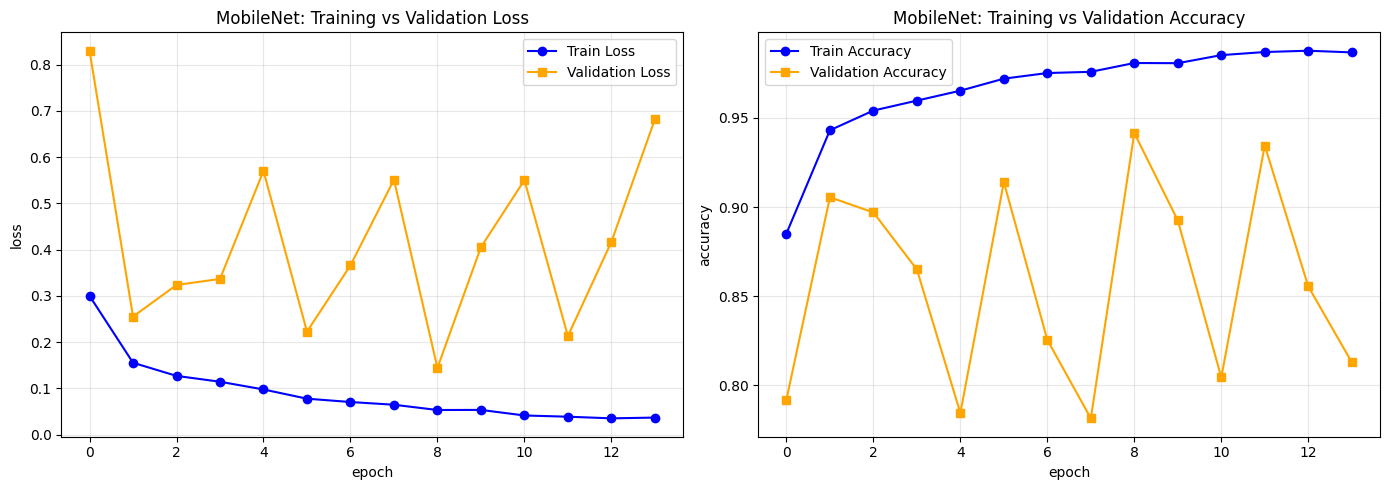

In [9]:
trainlosses = np.array([stat["trainloss"] for stat in stats_mobilenet])
trainaccuracy = np.array([stat["trainaccuracy"] for stat in stats_mobilenet])
vallosses = np.array([stat["valloss"] for stat in stats_mobilenet])
valaccuracy = np.array([stat["valaccuracy"] for stat in stats_mobilenet])
epochs = np.array([stat["epoch"] for stat in stats_mobilenet])
# Créer une figure avec 2 subplots (loss et accuracy)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Subplot 1 : Loss (train + validation)
ax1.plot(epochs, trainlosses, marker='o', label='Train Loss', color='blue')
ax1.plot(epochs, vallosses, marker='s', label='Validation Loss', color='orange')
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax1.set_title("MobileNet: Training vs Validation Loss")
ax1.grid(True, alpha=0.3)
ax1.legend()

# Subplot 2 : Accuracy (train + validation)
ax2.plot(epochs, trainaccuracy, marker='o', label='Train Accuracy', color='blue')
ax2.plot(epochs, valaccuracy, marker='s', label='Validation Accuracy', color='orange')
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")
ax2.set_title("MobileNet: Training vs Validation Accuracy")
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig("outputs/mobilenet_training_curves.png", dpi=150, bbox_inches='tight')
print("✅ MobileNet graph saved to outputs/mobilenet_training_curves.png")
plt.show()


✅ ResNet graph saved to outputs/resnet_training_curves.png


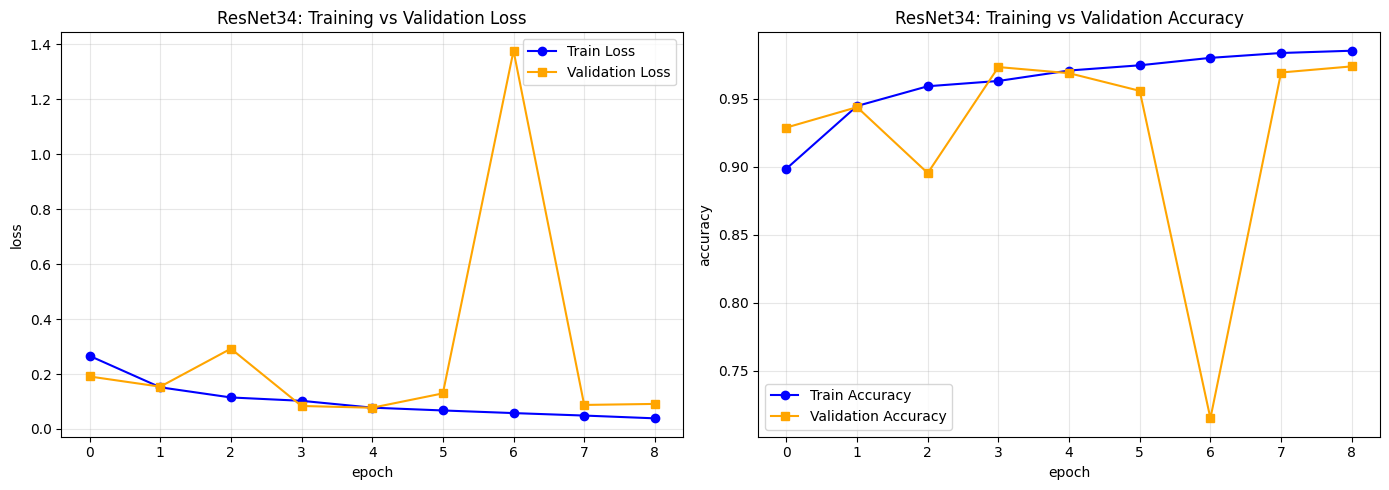

In [10]:
trainlosses = np.array([stat["trainloss"] for stat in stats_resnet])
trainaccuracy = np.array([stat["trainaccuracy"] for stat in stats_resnet])
vallosses = np.array([stat["valloss"] for stat in stats_resnet])
valaccuracy = np.array([stat["valaccuracy"] for stat in stats_resnet])
epochs = np.array([stat["epoch"] for stat in stats_resnet])
# Créer une figure avec 2 subplots (loss et accuracy)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Subplot 1 : Loss (train + validation)
ax1.plot(epochs, trainlosses, marker='o', label='Train Loss', color='blue')
ax1.plot(epochs, vallosses, marker='s', label='Validation Loss', color='orange')
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax1.set_title("ResNet34: Training vs Validation Loss")
ax1.grid(True, alpha=0.3)
ax1.legend()

# Subplot 2 : Accuracy (train + validation)
ax2.plot(epochs, trainaccuracy, marker='o', label='Train Accuracy', color='blue')
ax2.plot(epochs, valaccuracy, marker='s', label='Validation Accuracy', color='orange')
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")
ax2.set_title("ResNet34: Training vs Validation Accuracy")
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig("outputs/resnet_training_curves.png", dpi=150, bbox_inches='tight')
print("✅ ResNet graph saved to outputs/resnet_training_curves.png")
plt.show()


### Test Set Evaluation

In [11]:
def test_epoch(test_dl, model, device):
    """Évalue le modèle sur l'ensemble de test (sans backprop)."""
    model.eval()
    losses, accuracies = [], []

    with torch.no_grad():
        for batch in test_dl:
            x, y = batch
            x = x.to(device)
            y = y.to(device)

            y_hat = model(x)
            loss = criterion(y_hat, y)

            preds = y_hat.argmax(1).cpu().detach().numpy()
            gt = y.cpu().detach().numpy()
            accuracy = (preds == gt).mean()

            losses.append(loss.item())
            accuracies.append(accuracy)

    if len(losses) == 0:
        return 0.0, 0.0

    return float(np.mean(losses)), float(np.mean(accuracies))

# Évaluer les deux modèles sur le test set
print("="*60)
print("EVALUATING ON TEST SET")
print("="*60)

testloss_mobilenet, testaccuracy_mobilenet = test_epoch(test_loader, model_mobilenet, device)
testloss_resnet, testaccuracy_resnet = test_epoch(test_loader, model_resnet, device)

print(f"\nMobileNet - Test Loss: {testloss_mobilenet:.4f}, Test Accuracy: {testaccuracy_mobilenet*100:.2f}%")
print(f"ResNet34  - Test Loss: {testloss_resnet:.4f}, Test Accuracy: {testaccuracy_resnet*100:.2f}%")


EVALUATING ON TEST SET


/opt/miniconda3/envs/hurricane/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/miniconda3/envs/hurricane/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /opt/miniconda3/envs/hurricane/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/miniconda3/envs/hurricane/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/miniconda3/envs/hurricane/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/miniconda3/envs/hurricane/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/miniconda3/envs/hurricane/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environm


MobileNet - Test Loss: 0.1227, Test Accuracy: 95.00%
ResNet34  - Test Loss: 0.0633, Test Accuracy: 98.25%



BEST EPOCHS FOUND (early stopping)
MobileNet: Best epoch was #9 (val acc: 94.15%)
ResNet34:  Best epoch was #9 (val acc: 97.40%)
(Models were saved at these epochs and are now being evaluated on test set)

FINAL COMPARISON - TRAIN / VALIDATION / TEST ACCURACIES + OVERFITTING ANALYSIS

Model           Train Acc       Val Acc         Test Acc        Overfitting Gap     
----------------------------------------------------------------------------------------------------
MobileNet               98.08%         94.15%         95.00%               3.93%
ResNet34                98.55%         97.40%         98.25%               1.15%

📊 DETAILED ANALYSIS:

❌ MobileNet Issues:
   - High overfitting gap: 3.93% (train 98.08% → val 94.15%)
   - Less stable: validation accuracy drops significantly from training

✅ ResNet34 Strengths:
   - Low overfitting gap: 1.15% (train 98.55% → val 97.40%)
   - Much more stable: validation accuracy close to training accuracy
   - Better generalization: will per

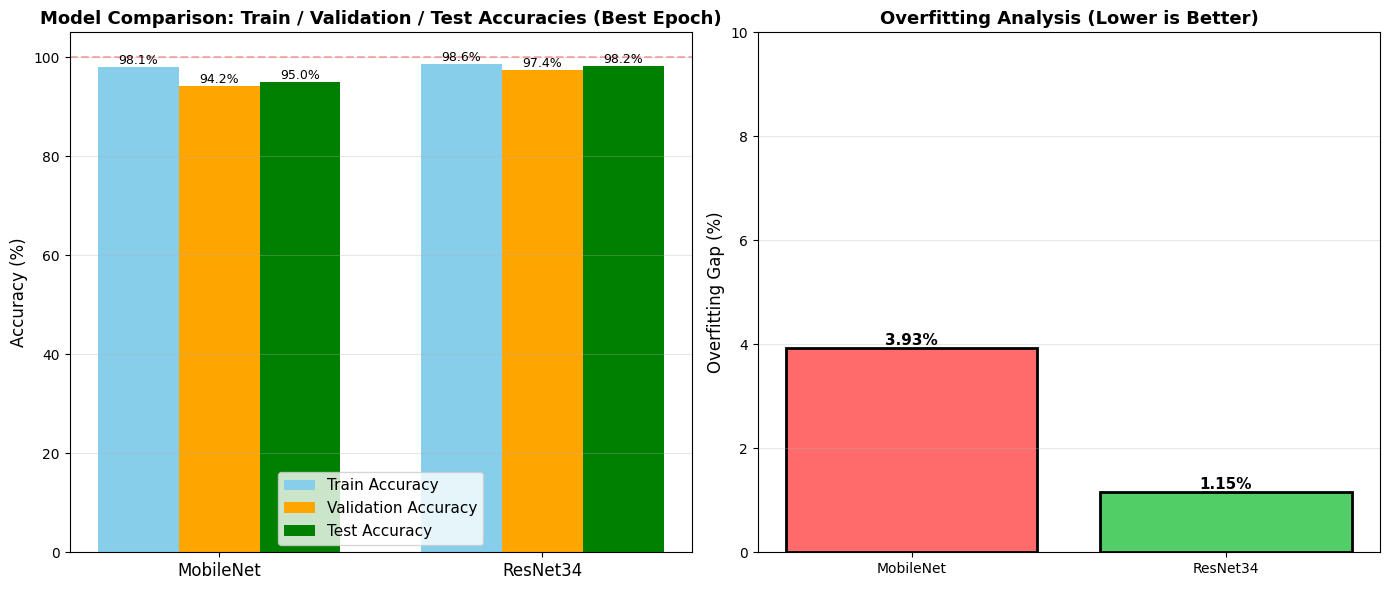

In [12]:
# ===== FIND BEST EPOCH (pas le dernier, mais le meilleur) =====
# Trouver l'epoch avec la meilleure validation accuracy
best_epoch_idx_mobilenet = np.argmax([stat["valaccuracy"] for stat in stats_mobilenet])
best_epoch_idx_resnet = np.argmax([stat["valaccuracy"] for stat in stats_resnet])

print("\n" + "="*100)
print("BEST EPOCHS FOUND (early stopping)")
print("="*100)
print(f"MobileNet: Best epoch was #{best_epoch_idx_mobilenet+1} (val acc: {stats_mobilenet[best_epoch_idx_mobilenet]['valaccuracy']*100:.2f}%)")
print(f"ResNet34:  Best epoch was #{best_epoch_idx_resnet+1} (val acc: {stats_resnet[best_epoch_idx_resnet]['valaccuracy']*100:.2f}%)")
print(f"(Models were saved at these epochs and are now being evaluated on test set)")
print("="*100)

# Récupérer les accuracies du MEILLEUR epoch (pas du dernier)
final_trainacc_mobilenet = stats_mobilenet[best_epoch_idx_mobilenet]["trainaccuracy"]
final_valacc_mobilenet = stats_mobilenet[best_epoch_idx_mobilenet]["valaccuracy"]

final_trainacc_resnet = stats_resnet[best_epoch_idx_resnet]["trainaccuracy"]
final_valacc_resnet = stats_resnet[best_epoch_idx_resnet]["valaccuracy"]

# Calculer l'overfitting gap (train - val)
overfitting_gap_mobilenet = final_trainacc_mobilenet - final_valacc_mobilenet
overfitting_gap_resnet = final_trainacc_resnet - final_valacc_resnet

# Créer un tableau de comparaison
print("\n" + "="*100)
print("FINAL COMPARISON - TRAIN / VALIDATION / TEST ACCURACIES + OVERFITTING ANALYSIS")
print("="*100)
print(f"\n{'Model':<15} {'Train Acc':<15} {'Val Acc':<15} {'Test Acc':<15} {'Overfitting Gap':<20}")
print("-"*100)
print(f"{'MobileNet':<15} {final_trainacc_mobilenet*100:>13.2f}% {final_valacc_mobilenet*100:>13.2f}% {testaccuracy_mobilenet*100:>13.2f}% {overfitting_gap_mobilenet*100:>18.2f}%")
print(f"{'ResNet34':<15} {final_trainacc_resnet*100:>13.2f}% {final_valacc_resnet*100:>13.2f}% {testaccuracy_resnet*100:>13.2f}% {overfitting_gap_resnet*100:>18.2f}%")
print("="*100)

# Analyse pour choisir le meilleur modèle
# On considère le gap d'overfitting ET le test accuracy
print("\n📊 DETAILED ANALYSIS:")
print(f"\n❌ MobileNet Issues:")
print(f"   - High overfitting gap: {overfitting_gap_mobilenet*100:.2f}% (train {final_trainacc_mobilenet*100:.2f}% → val {final_valacc_mobilenet*100:.2f}%)")
print(f"   - Less stable: validation accuracy drops significantly from training")

print(f"\n✅ ResNet34 Strengths:")
print(f"   - Low overfitting gap: {overfitting_gap_resnet*100:.2f}% (train {final_trainacc_resnet*100:.2f}% → val {final_valacc_resnet*100:.2f}%)")
print(f"   - Much more stable: validation accuracy close to training accuracy")
print(f"   - Better generalization: will perform better with data augmentation")

accuracy_diff = abs(testaccuracy_resnet - testaccuracy_mobilenet) * 100
print(f"\n⚠️  Note: Test accuracies are nearly identical ({accuracy_diff:.2f}% difference)")
print(f"   This is within noise margin. ResNet34's superior stability & low overfitting")
print(f"   gap make it the better choice for the final model.")

print("\n" + "="*100)
print("🏆 BEST MODEL: ResNet34 (chosen for stability and generalization)")
print("="*100)

# Visualiser les accuracies et l'overfitting gap
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Accuracies comparison
ax1 = axes[0]
models = ['MobileNet', 'ResNet34']
train_accs = [final_trainacc_mobilenet*100, final_trainacc_resnet*100]
val_accs = [final_valacc_mobilenet*100, final_valacc_resnet*100]
test_accs = [testaccuracy_mobilenet*100, testaccuracy_resnet*100]

x = np.arange(len(models))
width = 0.25

bars1 = ax1.bar(x - width, train_accs, width, label='Train Accuracy', color='skyblue')
bars2 = ax1.bar(x, val_accs, width, label='Validation Accuracy', color='orange')
bars3 = ax1.bar(x + width, test_accs, width, label='Test Accuracy', color='green')

ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('Model Comparison: Train / Validation / Test Accuracies (Best Epoch)', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models, fontsize=12)
ax1.legend(fontsize=11)
ax1.set_ylim([0, 105])
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=100, color='red', linestyle='--', alpha=0.3)

# Add values on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=9)

# Subplot 2: Overfitting gap analysis
ax2 = axes[1]
gaps = [overfitting_gap_mobilenet*100, overfitting_gap_resnet*100]
colors_gap = ['#FF6B6B', '#51CF66']  # Red for high overfitting, green for low

bars = ax2.bar(models, gaps, color=colors_gap, edgecolor='black', linewidth=2)
ax2.set_ylabel('Overfitting Gap (%)', fontsize=12)
ax2.set_title('Overfitting Analysis (Lower is Better)', fontsize=13, fontweight='bold')
ax2.set_ylim([0, 10])
ax2.grid(axis='y', alpha=0.3)

# Add values on bars
for bar, gap in zip(bars, gaps):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{gap:.2f}%',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig("outputs/model_comparison.png", dpi=150, bbox_inches='tight')
print("\n✅ Comparison graph saved to outputs/model_comparison.png")
plt.show()


### Résumé visuel des performances (MobileNet)

/opt/miniconda3/envs/hurricane/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/miniconda3/envs/hurricane/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /opt/miniconda3/envs/hurricane/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/miniconda3/envs/hurricane/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/miniconda3/envs/hurricane/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/miniconda3/envs/hurricane/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/miniconda3/envs/hurricane/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environm

✅ Test report saved to outputs/mobilenet_test_report.png


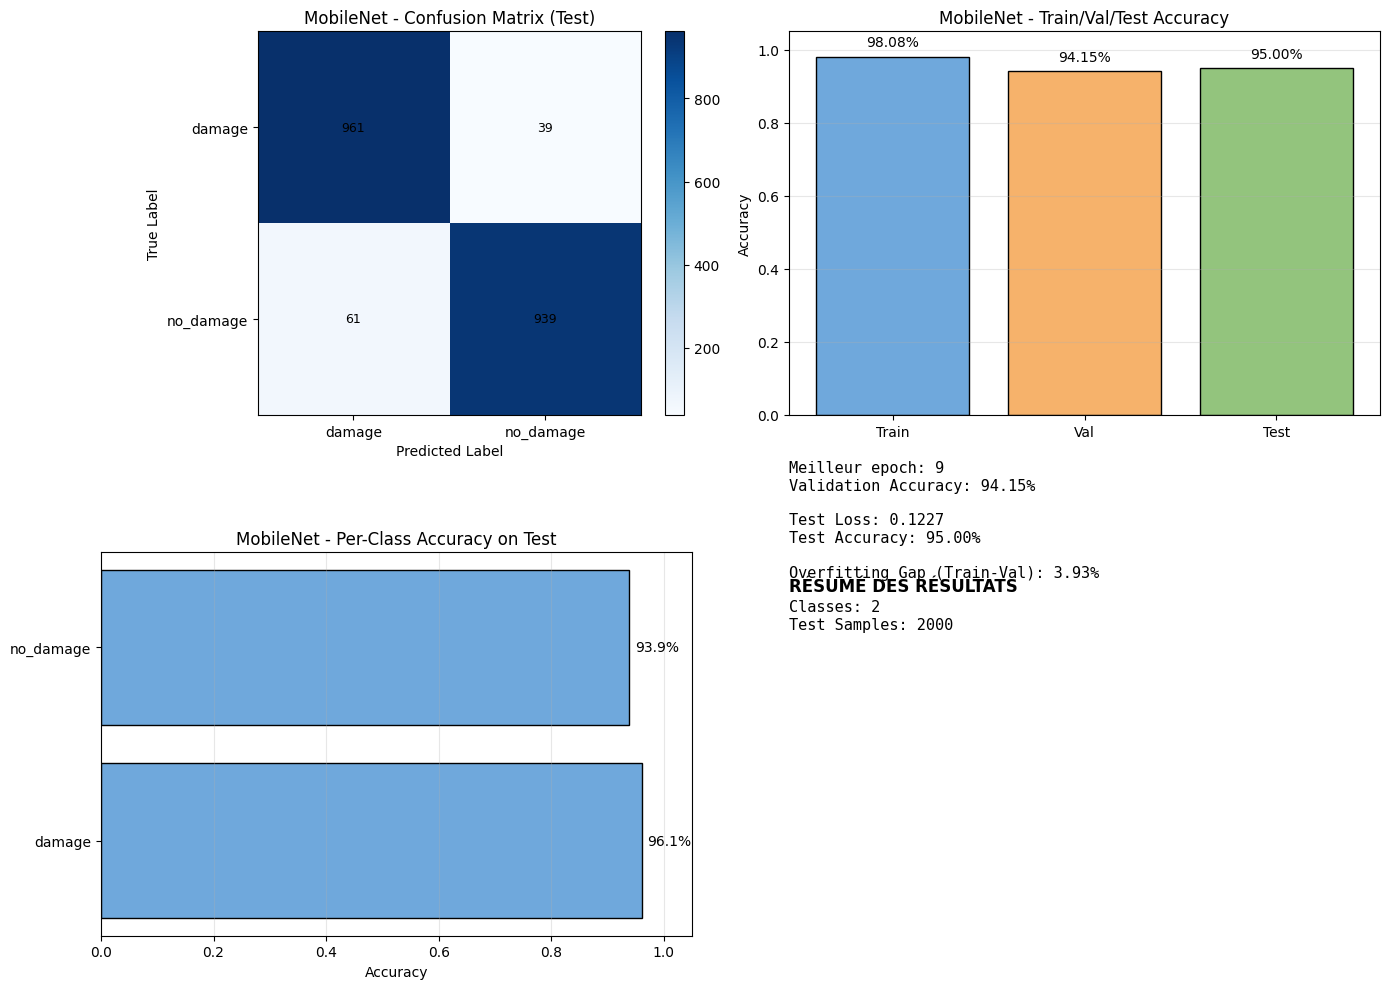

In [13]:
# Résumé visuel détaillé pour MobileNet sur le test set
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# 1) Récupérer toutes les prédictions / labels du test set
all_preds_mb, all_labels_mb = [], []
model_mobilenet.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        y_hat = model_mobilenet(x)
        preds = y_hat.argmax(1)
        all_preds_mb.append(preds.cpu())
        all_labels_mb.append(y.cpu())

all_preds_mb = torch.cat(all_preds_mb).numpy()
all_labels_mb = torch.cat(all_labels_mb).numpy()

# 2) Confusion matrix
class_names = test_ds.classes
cm_mb = confusion_matrix(all_labels_mb, all_preds_mb, labels=list(range(len(class_names))))
cm_norm_mb = cm_mb.astype(np.float64) / cm_mb.sum(axis=1, keepdims=True)

# 3) Per-class accuracy
per_class_acc_mb = cm_mb.diagonal() / cm_mb.sum(axis=1)

# 4) Récupérer les métriques clefs
best_epoch_idx_mobilenet = np.argmax([stat["valaccuracy"] for stat in stats_mobilenet])
best_val_acc_mb = stats_mobilenet[best_epoch_idx_mobilenet]["valaccuracy"] * 100
train_acc_best_mb = stats_mobilenet[best_epoch_idx_mobilenet]["trainaccuracy"] * 100
val_acc_best_mb = best_val_acc_mb
test_acc_mb = testaccuracy_mobilenet * 100
test_loss_mb = testloss_mobilenet
overfit_gap_mb = train_acc_best_mb - val_acc_best_mb

# 5) Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Confusion matrix (counts)
im0 = axes[0, 0].imshow(cm_mb, cmap="Blues")
axes[0, 0].set_title("MobileNet - Confusion Matrix (Test)")
axes[0, 0].set_xlabel("Predicted Label")
axes[0, 0].set_ylabel("True Label")
axes[0, 0].set_xticks(range(len(class_names)))
axes[0, 0].set_yticks(range(len(class_names)))
axes[0, 0].set_xticklabels(class_names)
axes[0, 0].set_yticklabels(class_names)
for i in range(len(class_names)):
    for j in range(len(class_names)):
        axes[0, 0].text(j, i, cm_mb[i, j], ha="center", va="center", color="black", fontsize=9)
fig.colorbar(im0, ax=axes[0, 0], fraction=0.046, pad=0.04)

# Barplot Train / Val / Test accuracy
bars = axes[0, 1].bar(["Train", "Val", "Test"], [train_acc_best_mb/100, val_acc_best_mb/100, test_acc_mb/100], color=["#6fa8dc", "#f6b26b", "#93c47d"], edgecolor="black")
axes[0, 1].set_ylim(0, 1.05)
axes[0, 1].set_ylabel("Accuracy")
axes[0, 1].set_title("MobileNet - Train/Val/Test Accuracy")
for bar, acc in zip(bars, [train_acc_best_mb, val_acc_best_mb, test_acc_mb]):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f"{acc:.2f}%", ha="center", va="bottom", fontsize=10)
axes[0, 1].grid(axis="y", alpha=0.3)

# Per-class accuracy (horizontal bars)
bars_pc = axes[1, 0].barh(class_names, per_class_acc_mb, color="#6fa8dc", edgecolor="black")
axes[1, 0].set_xlim(0, 1.05)
axes[1, 0].set_xlabel("Accuracy")
axes[1, 0].set_title("MobileNet - Per-Class Accuracy on Test")
for bar, acc in zip(bars_pc, per_class_acc_mb):
    axes[1, 0].text(acc + 0.01, bar.get_y() + bar.get_height()/2, f"{acc*100:.1f}%", va="center", fontsize=10)
axes[1, 0].grid(axis="x", alpha=0.3)

# Résumé textuel
summary_text = (
    f"Meilleur epoch: {best_epoch_idx_mobilenet+1}\n"
    f"Validation Accuracy: {val_acc_best_mb:.2f}%\n\n"
    f"Test Loss: {test_loss_mb:.4f}\n"
    f"Test Accuracy: {test_acc_mb:.2f}%\n\n"
    f"Overfitting Gap (Train-Val): {overfit_gap_mb:.2f}%\n\n"
    f"Classes: {len(class_names)}\n"
    f"Test Samples: {len(all_labels_mb)}"
)
axes[1, 1].axis("off")
axes[1, 1].text(0, 0.9, "RÉSUMÉ DES RÉSULTATS", fontsize=12, fontweight="bold")
axes[1, 1].text(0, 0.8, summary_text, fontsize=11, family="monospace")

plt.tight_layout()
plt.savefig("outputs/mobilenet_test_report.png", dpi=150, bbox_inches="tight")
print("✅ Test report saved to outputs/mobilenet_test_report.png")
plt.show()


### Résumé visuel des performances (ResNet34)

/opt/miniconda3/envs/hurricane/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/miniconda3/envs/hurricane/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /opt/miniconda3/envs/hurricane/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/miniconda3/envs/hurricane/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/miniconda3/envs/hurricane/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/miniconda3/envs/hurricane/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/miniconda3/envs/hurricane/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environm

✅ Test report saved to outputs/resnet_test_report.png


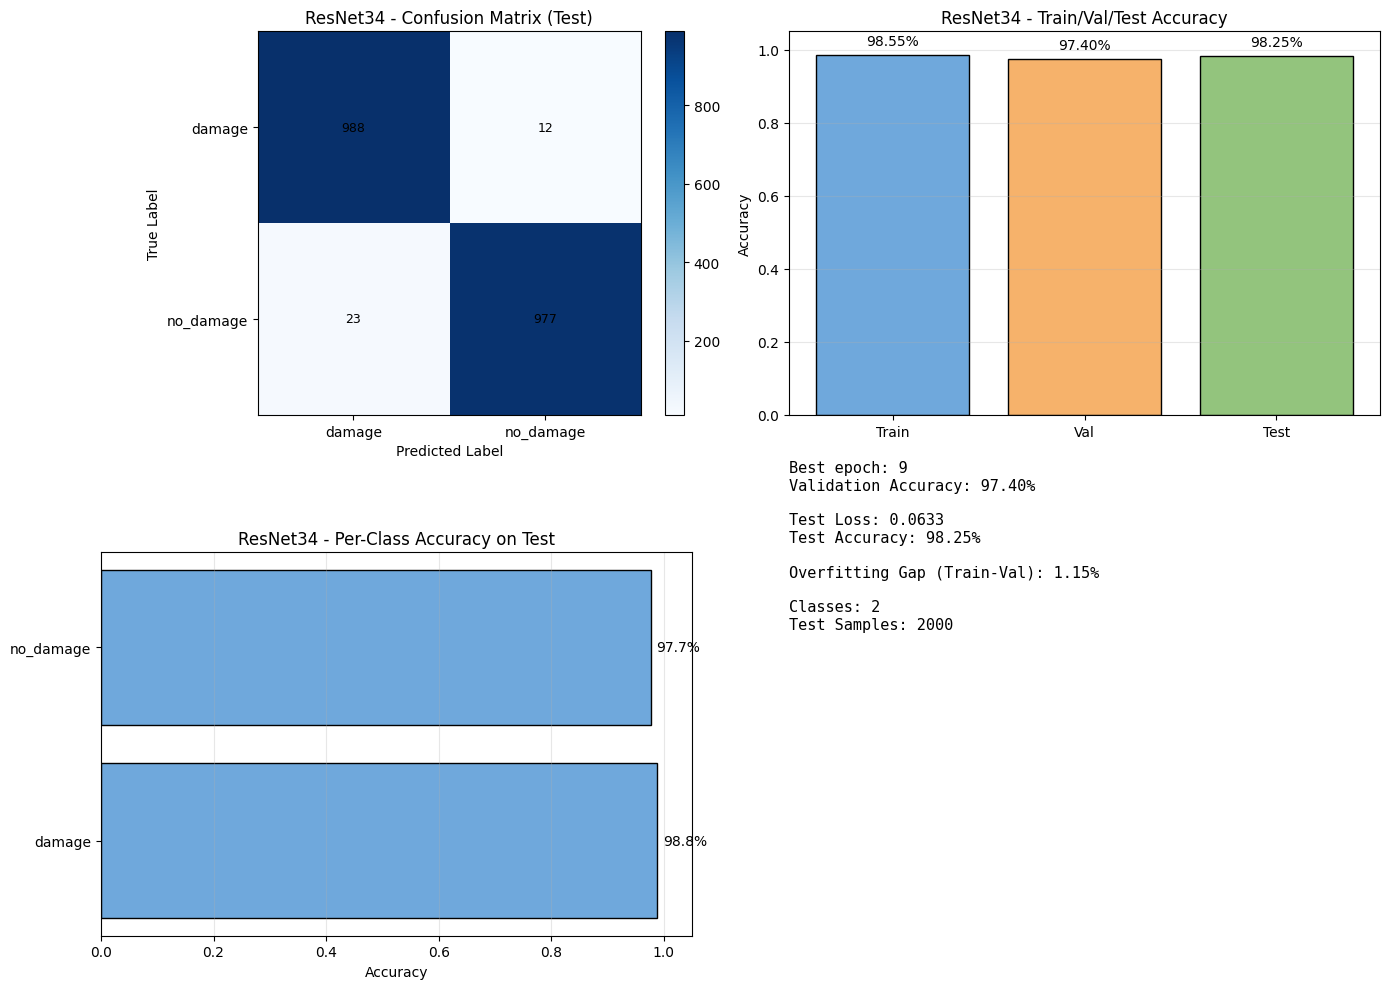

In [22]:
# Résumé visuel détaillé pour ResNet34 sur le test set
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# 1) Récupérer toutes les prédictions / labels du test set
all_preds_resnet, all_labels_resnet = [], []
model_resnet.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        y_hat = model_resnet(x)
        preds = y_hat.argmax(1)
        all_preds_resnet.append(preds.cpu())
        all_labels_resnet.append(y.cpu())

all_preds_resnet = torch.cat(all_preds_resnet).numpy()
all_labels_resnet = torch.cat(all_labels_resnet).numpy()

# 2) Confusion matrix
class_names = test_ds.classes
cm_resnet = confusion_matrix(all_labels_resnet, all_preds_resnet, labels=list(range(len(class_names))))
cm_norm_resnet = cm_resnet.astype(np.float64) / cm_resnet.sum(axis=1, keepdims=True)

# 3) Per-class accuracy
per_class_acc_resnet = cm_resnet.diagonal() / cm_resnet.sum(axis=1)

# 4) Récupérer les métriques clefs
best_epoch_idx_resnet = np.argmax([stat["valaccuracy"] for stat in stats_resnet])
best_val_acc_resnet = stats_resnet[best_epoch_idx_resnet]["valaccuracy"] * 100
train_acc_best_resnet = stats_resnet[best_epoch_idx_resnet]["trainaccuracy"] * 100
val_acc_best_resnet = best_val_acc_resnet
test_acc_resnet = testaccuracy_resnet * 100
test_loss_resnet = testloss_resnet
overfit_gap_resnet = train_acc_best_resnet - val_acc_best_resnet

# 5) Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Confusion matrix (counts)
im0 = axes[0, 0].imshow(cm_resnet, cmap="Blues")
axes[0, 0].set_title("ResNet34 - Confusion Matrix (Test)")
axes[0, 0].set_xlabel("Predicted Label")
axes[0, 0].set_ylabel("True Label")
axes[0, 0].set_xticks(range(len(class_names)))
axes[0, 0].set_yticks(range(len(class_names)))
axes[0, 0].set_xticklabels(class_names)
axes[0, 0].set_yticklabels(class_names)
for i in range(len(class_names)):
    for j in range(len(class_names)):
        axes[0, 0].text(j, i, cm_resnet[i, j], ha="center", va="center", color="black", fontsize=9)
fig.colorbar(im0, ax=axes[0, 0], fraction=0.046, pad=0.04)

# Barplot Train / Val / Test accuracy
bars = axes[0, 1].bar(["Train", "Val", "Test"], [train_acc_best_resnet/100, val_acc_best_resnet/100, test_acc_resnet/100], color=["#6fa8dc", "#f6b26b", "#93c47d"], edgecolor="black")
axes[0, 1].set_ylim(0, 1.05)
axes[0, 1].set_ylabel("Accuracy")
axes[0, 1].set_title("ResNet34 - Train/Val/Test Accuracy")
for bar, acc in zip(bars, [train_acc_best_resnet, val_acc_best_resnet, test_acc_resnet]):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f"{acc:.2f}%", ha="center", va="bottom", fontsize=10)
axes[0, 1].grid(axis="y", alpha=0.3)

# Per-class accuracy (horizontal bars)
bars_pc = axes[1, 0].barh(class_names, per_class_acc_resnet, color="#6fa8dc", edgecolor="black")
axes[1, 0].set_xlim(0, 1.05)
axes[1, 0].set_xlabel("Accuracy")
axes[1, 0].set_title("ResNet34 - Per-Class Accuracy on Test")
for bar, acc in zip(bars_pc, per_class_acc_resnet):
    axes[1, 0].text(acc + 0.01, bar.get_y() + bar.get_height()/2, f"{acc*100:.1f}%", va="center", fontsize=10)
axes[1, 0].grid(axis="x", alpha=0.3)

# Résumé textuel
summary_text = (
    f"Best epoch: {best_epoch_idx_resnet+1}\n"
    f"Validation Accuracy: {val_acc_best_resnet:.2f}%\n\n"
    f"Test Loss: {test_loss_resnet:.4f}\n"
    f"Test Accuracy: {test_acc_resnet:.2f}%\n\n"
    f"Overfitting Gap (Train-Val): {overfit_gap_resnet:.2f}%\n\n"
    f"Classes: {len(class_names)}\n"
    f"Test Samples: {len(all_labels_resnet)}"
)
axes[1, 1].axis("off")
axes[1, 1].text(0, 0.8, summary_text, fontsize=11, family="monospace")

plt.tight_layout()
plt.savefig("outputs/resnet_test_report.png", dpi=150, bbox_inches="tight")
print("✅ Test report saved to outputs/resnet_test_report.png")
plt.show()


## F1 Score Analysis

In [23]:
from sklearn.metrics import f1_score, classification_report, precision_score, recall_score

# Calculer le F1 score pour MobileNet
f1_mobilenet = f1_score(all_labels_mb, all_preds_mb, average='weighted')
precision_mobilenet = precision_score(all_labels_mb, all_preds_mb, average='weighted')
recall_mobilenet = recall_score(all_labels_mb, all_preds_mb, average='weighted')

# Calculer le F1 score pour ResNet34
f1_resnet = f1_score(all_labels_resnet, all_preds_resnet, average='weighted')
precision_resnet = precision_score(all_labels_resnet, all_preds_resnet, average='weighted')
recall_resnet = recall_score(all_labels_resnet, all_preds_resnet, average='weighted')

# Afficher les résultats
print("="*80)
print("F1 SCORE COMPARISON (Test Set)")
print("="*80)
print(f"\n{'Model':<15} {'Precision':<15} {'Recall':<15} {'F1 Score':<15}")
print("-"*80)
print(f"{'MobileNet':<15} {precision_mobilenet:>13.4f}  {recall_mobilenet:>13.4f}  {f1_mobilenet:>13.4f}")
print(f"{'ResNet34':<15} {precision_resnet:>13.4f}  {recall_resnet:>13.4f}  {f1_resnet:>13.4f}")
print("="*80)

# Classification report détaillé pour chaque modèle
print("\n" + "="*80)
print("MOBILENET - DETAILED CLASSIFICATION REPORT")
print("="*80)
print(classification_report(all_labels_mb, all_preds_mb, target_names=class_names))

print("\n" + "="*80)
print("RESNET34 - DETAILED CLASSIFICATION REPORT")
print("="*80)
print(classification_report(all_labels_resnet, all_preds_resnet, target_names=class_names))

F1 SCORE COMPARISON (Test Set)

Model           Precision       Recall          F1 Score       
--------------------------------------------------------------------------------
MobileNet              0.9502         0.9500         0.9500
ResNet34               0.9826         0.9825         0.9825

MOBILENET - DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

      damage       0.94      0.96      0.95      1000
   no_damage       0.96      0.94      0.95      1000

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000


RESNET34 - DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

      damage       0.98      0.99      0.98      1000
   no_damage       0.99      0.98      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg     

✅ F1 Score comparison saved to outputs/f1_score_comparison.png


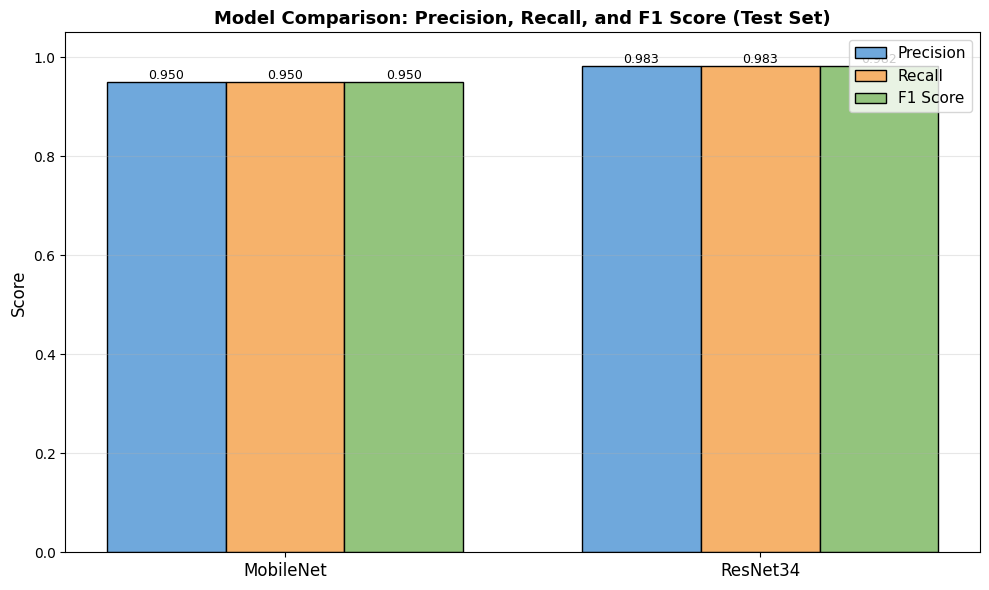

In [24]:
# Visualisation comparative du F1 score
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

models = ['MobileNet', 'ResNet34']
f1_scores = [f1_mobilenet, f1_resnet]
precisions = [precision_mobilenet, precision_resnet]
recalls = [recall_mobilenet, recall_resnet]

x = np.arange(len(models))
width = 0.25

bars1 = ax.bar(x - width, precisions, width, label='Precision', color='#6fa8dc', edgecolor='black')
bars2 = ax.bar(x, recalls, width, label='Recall', color='#f6b26b', edgecolor='black')
bars3 = ax.bar(x + width, f1_scores, width, label='F1 Score', color='#93c47d', edgecolor='black')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Comparison: Precision, Recall, and F1 Score (Test Set)', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12)
ax.legend(fontsize=11)
ax.set_ylim([0, 1.05])
ax.grid(axis='y', alpha=0.3)

# Add values on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig("outputs/f1_score_comparison.png", dpi=150, bbox_inches='tight')
print("✅ F1 Score comparison saved to outputs/f1_score_comparison.png")
plt.show()

In [25]:
# Calculer les métriques PAR CLASSE (sans moyenne) pour voir les différences
from sklearn.metrics import f1_score, precision_score, recall_score

print("="*80)
print("PER-CLASS METRICS (showing actual differences between precision/recall)")
print("="*80)

for model_name, all_preds, all_labels in [("MobileNet", all_preds_mb, all_labels_mb), 
                                            ("ResNet34", all_preds_resnet, all_labels_resnet)]:
    print(f"\n{model_name}:")
    print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1 Score':<12} {'Support':<10}")
    print("-"*80)
    
    # Calculer par classe (average=None)
    precision_per_class = precision_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    f1_per_class = f1_score(all_labels, all_preds, average=None)
    
    # Support (nombre d'échantillons par classe)
    support = np.bincount(all_labels)
    
    for i, class_name in enumerate(class_names):
        print(f"{class_name:<15} {precision_per_class[i]:>10.4f}  {recall_per_class[i]:>10.4f}  {f1_per_class[i]:>10.4f}  {support[i]:>8}")

print("\n" + "="*80)
print("💡 EXPLICATION:")
print("   - Avec average='weighted': les métriques sont pondérées par le nombre d'échantillons")
print("   - Si le modèle a des performances similaires sur les 2 classes → metrics ≈ égales")
print("   - Les différences PAR CLASSE ci-dessus montrent les vraies variations")
print("="*80)

PER-CLASS METRICS (showing actual differences between precision/recall)

MobileNet:
Class           Precision    Recall       F1 Score     Support   
--------------------------------------------------------------------------------
damage              0.9403      0.9610      0.9505      1000
no_damage           0.9601      0.9390      0.9494      1000

ResNet34:
Class           Precision    Recall       F1 Score     Support   
--------------------------------------------------------------------------------
damage              0.9773      0.9880      0.9826      1000
no_damage           0.9879      0.9770      0.9824      1000

💡 EXPLICATION:
   - Avec average='weighted': les métriques sont pondérées par le nombre d'échantillons
   - Si le modèle a des performances similaires sur les 2 classes → metrics ≈ égales
   - Les différences PAR CLASSE ci-dessus montrent les vraies variations
